# TL;DR

The goal of this notebook is to visualize COVID-19 infections using data from https://github.com/CSSEGISandData/COVID-19.  

Visualizations found in this notebook:
- [Top 20 countries by cumulative confirmed COVID-19 cases](#top_countries_confirmed)
- [Top 10 countries by NEW confirmed COVID-19 cases](#top_countries_confirmed_new)
- [Time-series plots of infections in most infected countries](#time-series_countries)
- [Forecasts of infections/deaths 1 and 7 days in the future](#forecasts_countries)
- [Time-series plots of mortality](#time-series_country_mortality)
- [Mortality as currently measured, compared to expected based on WHO mortality expectations](#counry_mortality_expectations)
  - [Source of expectations](http://weekly.chinacdc.cn/en/article/id/e53946e2-c6c4-41e9-9a9b-fea8db1a8f51)
- [How many days behind is each country from Italy?](#days_behind)
- [US states with the most new infections](#states_most_infections)
- [Time-series plots of infections in most-infected states](#time-series_states)
- [Compare US state infections against Washington](#state_infections_vs_wa)
- [Compare US state infections against New York](#state_infections_vs_ny)
- [Mortality rate by US state](#mortality_by_us_state)

In [846]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



# Imports and definitions

In [847]:
import pandas as pd
import numpy as np
import os
import datetime
import re
from dateutil import parser
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = 12,6
plt.style.use('seaborn-dark-palette')
#plt.style.use('seaborn-darkgrid')
pd.options.display.max_columns = 300

def datetime_to_unixtime(dt):
    return (dt - datetime.datetime(1970, 1, 1)).total_seconds()

# Load data

In [848]:
# define paths to each raw file
d_ts = {}
d_ts['confirmed'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
d_ts['deaths'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
d_ts['recovered'] = '../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

# load in each CSV
d_data = {}
for key, file_path in d_ts.items():
    d_data[key] = pd.read_csv(file_path)

# Clean to long form

In [849]:
def clean_wide_to_long(dfp, key):
    # find columns with dates in them
    cols = list(dfp.columns)
    date_cols = [col for col in cols if re.findall('(\d+/\d+/\d+)', col)]  #if '/' in col
    non_date_cols = list(set(cols) - set(date_cols))
    
    # wide to long
    dfp_melt = pd.melt(dfp, id_vars=non_date_cols, value_vars=date_cols)
    dfp_melt = dfp_melt.rename(columns={'variable': 'date', 
                                        'value': key,
                                        'Country/Region': 'country',
                                        'Province/State': 'state',
                                       })
    dfp_melt['date'] = dfp_melt['date'].apply(parser.parse)
    dfp_melt[key] = dfp_melt[key].apply(float)
    return dfp_melt

In [850]:
# convert from wide to long form
d_dfps = {}
dfp = None
merge_cols = ['country', 'state', 'date']
for key, dfp_wide in d_data.items():
    print(f'metric: {key} at {datetime.datetime.now()}')
    d_dfps[key] = clean_wide_to_long(dfp_wide, key)
    
    if dfp is None:
        dfp = d_dfps[key].copy()
    else:
        dfp_temp = d_dfps[key][merge_cols + [key]]
        dfp = dfp.merge(dfp_temp, on=merge_cols, how='left')
        
print(f"Latest data from {dfp['date'].max().strftime('%Y-%m-%d')}")

metric: confirmed at 2020-03-21 19:56:59.023265
metric: deaths at 2020-03-21 19:57:00.376714
metric: recovered at 2020-03-21 19:57:01.850706
Latest data from 2020-03-21


In [851]:
# TEMP FIX - There are data issues on 2020-03-18; these are corrections that will hopefully be fixed
state_fixes_20200318 = {'New York': 3083, 
                        'Washington': 1187, 
                        'California': 870, 
                        'Florida': 330, 
                        'New Jersey': 427, 
                        'Louisiana': 280}
for state, val in state_fixes_20200318.items():
    dfp.loc[(dfp.country == 'US') & 
            (dfp['date'] == datetime.datetime(2020,3,18)) & 
            (dfp.state == state), 'confirmed'] = val

In [852]:
# aggregate by country (the US data is reported by state)
dfp_country = (dfp.groupby(['date', 'country'], as_index=False).
               agg({
                   'confirmed': np.sum,
                   'deaths': np.sum,
                   'recovered': np.sum,
               }))
dfp_country['active'] = dfp_country['confirmed'] - dfp_country['recovered']
dfp_country['confirmed_lag1'] = dfp_country.groupby(['country'])['confirmed'].shift(1)
dfp_country['confirmed_new'] = dfp_country['confirmed'] - dfp_country['confirmed_lag1']
dfp_country['deaths_lag1'] = dfp_country.groupby(['country'])['deaths'].shift(1)
dfp_country['deaths_new'] = dfp_country['deaths'] - dfp_country['deaths_lag1']
dfp_country['mortality_rate'] = dfp_country['deaths'] / dfp_country['confirmed']

<a id='top_countries_confirmed'></a>
##### Top 20 countries by cumulative confirmed COVID-19 cases

In [853]:
# get the top countries
id_cols = ['date', 'country']
value_cols = [
    'confirmed',
    'confirmed_new',
    'deaths',
    'deaths_new',
    'active',
    'mortality_rate',
]
dfp_top_countries = dfp_country[dfp_country['date'] == dfp_country['date'].max()][id_cols + value_cols]
dfp_top_countries = dfp_top_countries.sort_values(by='active', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_top_countries[key] = dfp_top_countries[key].apply(int)
dfp_top_countries.head(20)

,date,country,confirmed,confirmed_new,deaths,deaths_new,active,mortality_rate
0,2020-03-21,Italy,53578,6557,4825,793,47506,0.090056
1,2020-03-21,US,25489,6389,307,63,25489,0.012044
2,2020-03-21,Spain,25374,4964,1375,332,23249,0.054189
3,2020-03-21,Germany,22213,2365,84,17,21980,0.003782
4,2020-03-21,France,14431,1705,562,112,14419,0.038944
5,2020-03-21,Iran,20610,966,1556,123,12975,0.075497
6,2020-03-21,China,81305,55,3259,6,9448,0.040084
7,2020-03-21,"Korea, South",8799,147,102,8,7259,0.011592
8,2020-03-21,Switzerland,6575,1281,75,21,6560,0.011407
9,2020-03-21,United Kingdom,5067,1053,234,56,5000,0.046181


<a id='top_countries_confirmed_new'></a>
##### Top 10 countries by NEW confirmed COVID-19 cases

In [854]:
dfp_top_countries.sort_values(by='confirmed_new', ascending=0).head(10)

,date,country,confirmed,confirmed_new,deaths,deaths_new,active,mortality_rate
0,2020-03-21,Italy,53578,6557,4825,793,47506,0.090056
1,2020-03-21,US,25489,6389,307,63,25489,0.012044
2,2020-03-21,Spain,25374,4964,1375,332,23249,0.054189
3,2020-03-21,Germany,22213,2365,84,17,21980,0.003782
4,2020-03-21,France,14431,1705,562,112,14419,0.038944
8,2020-03-21,Switzerland,6575,1281,75,21,6560,0.011407
9,2020-03-21,United Kingdom,5067,1053,234,56,5000,0.046181
5,2020-03-21,Iran,20610,966,1556,123,12975,0.075497
10,2020-03-21,Netherlands,3640,637,137,30,3638,0.037637
12,2020-03-21,Belgium,2815,558,67,30,2552,0.023801


<a id='time-series_countries'></a>
# Time-series plots of infections in most infected countries

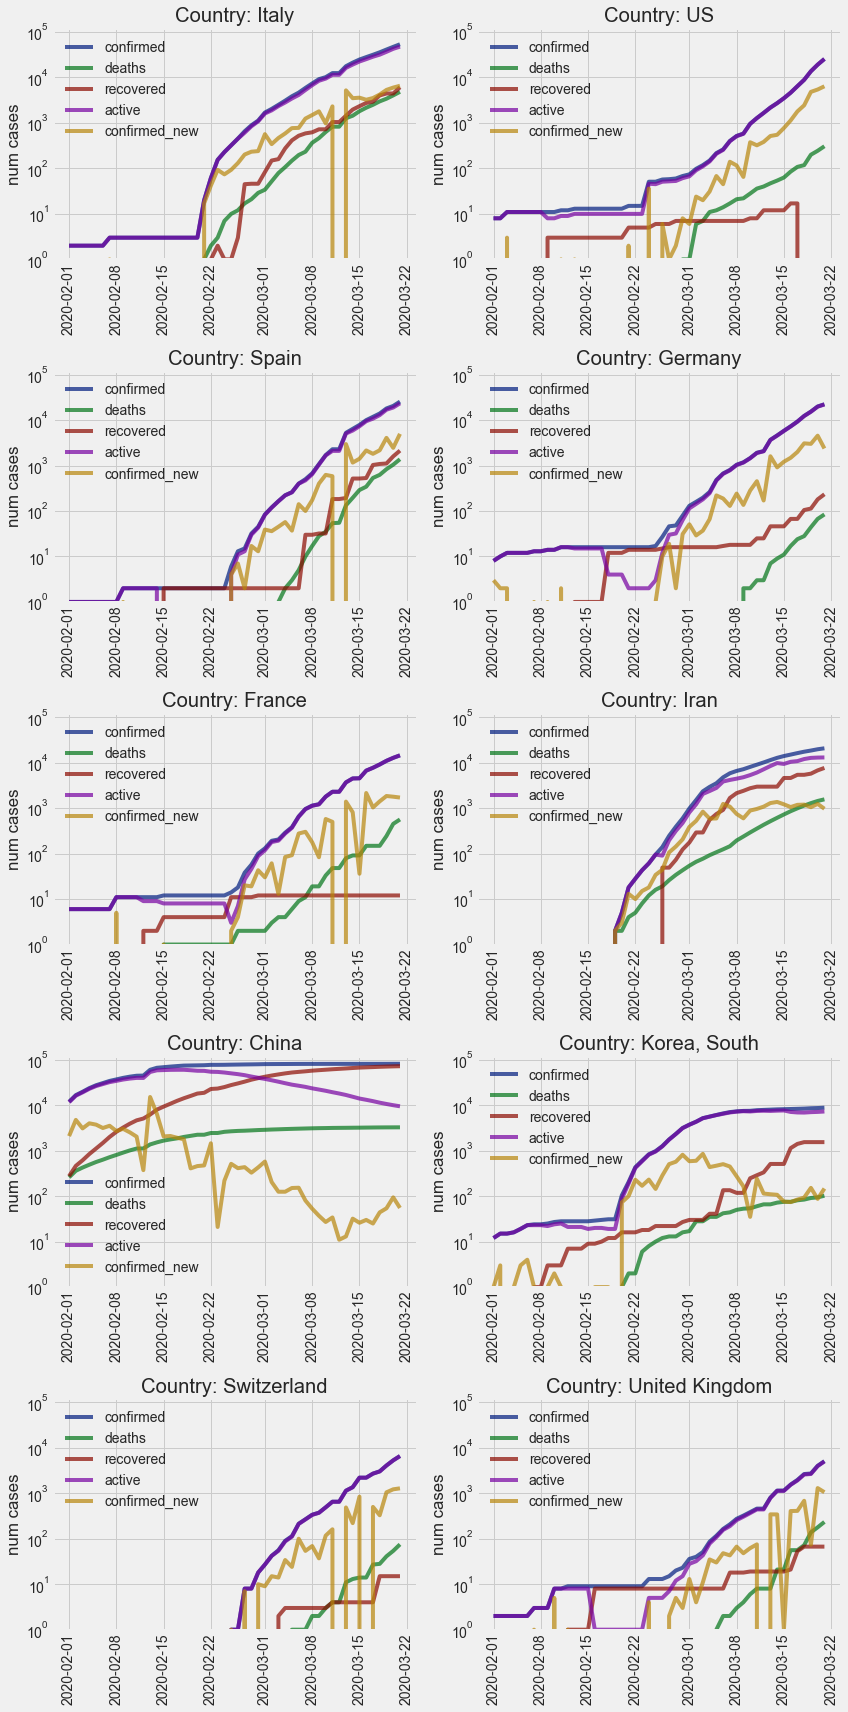

In [855]:
# plot the top countries
i = 1
n_countries = 10
n_columns = 2
n_rows = int(np.ceil(n_countries / n_columns))
plt.figure(figsize=(12,24))
y_max = dfp_top_countries['confirmed'].max() * 1.5
date_min = datetime.datetime(2020, 2, 1)

for country in dfp_top_countries.iloc[:n_countries]['country']:
    dfp_plot = dfp_country[(dfp_country['country'] == country) &
                           (dfp_country['date'] >= date_min)
                          ]
    plt.subplot(n_rows, n_columns, i)
    for key in list(d_data.keys()) + ['active', 'confirmed_new']:
        plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.7, label=key)
    plt.legend(loc='best')
    plt.ylabel('num cases')
    plt.title(f'Country: {country}')
    plt.yscale('log')
    plt.ylim([1, y_max])
    plt.xticks(rotation=90)
    
    i += 1
plt.tight_layout()
plt.show()

<a id='forecasts_countries'></a>
# Forecasts of infections/deaths 1 and 7 days in the future

For confirmed cases (`confirmed_pred`) and deaths (`deaths_pred`)

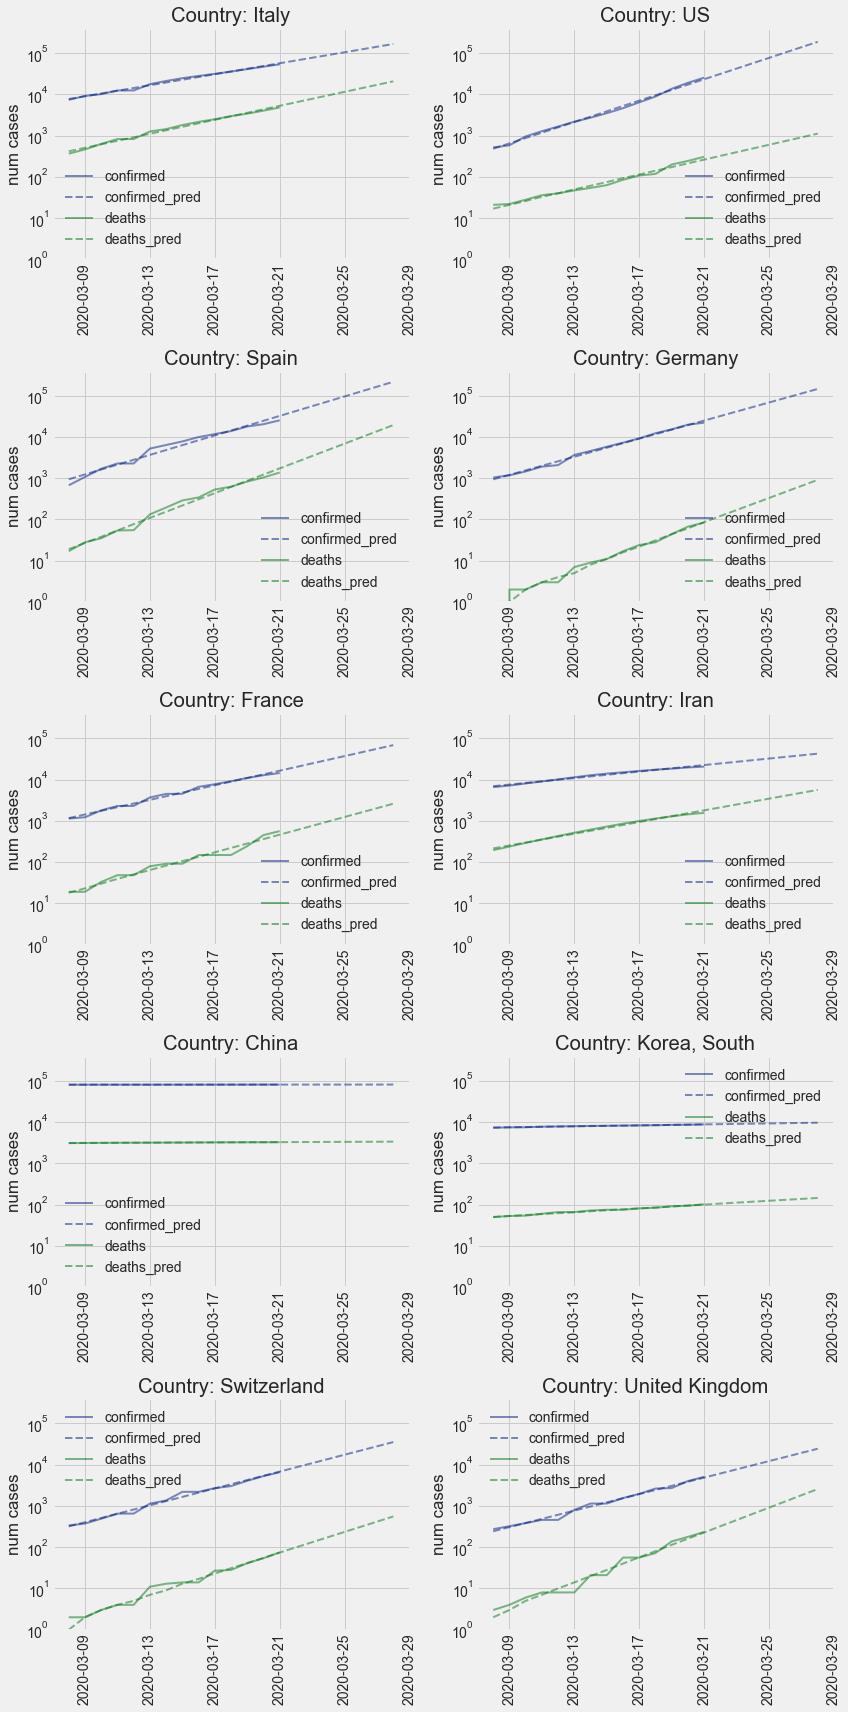

confirmed_pred            deaths_pred           
date               2020-03-22 2020-03-28  2020-03-22 2020-03-28
country                                                        
Italy                   66389     166832        6428      20743
Spain                   42578     217952        2448      19436
Iran                    24612      42435        2110       5618
China                   81268      81468        3285       3360
France                  20112      68284         590       2594
United Kingdom           6128      24399         322       2573
US                      31404     188126         323       1119
Germany                 32146     146219         121        911
Switzerland              8618      35394          99        556
Korea, South             8928       9681         106        145

In [893]:
# make predictions based on the last 2 weeks of data
date_2_weeks_ago = (dfp_country['date'].max() - datetime.timedelta(days=13))
dfp_country_recent = (dfp_country[dfp_country['date'] >= date_2_weeks_ago].
                      sort_values(by=['country', 'date'])
                     ).copy()

# clean data for fit (convert to log)
REGULARIZATION = 9E-1
dfp_country_recent['confirmed_log'] = dfp_country_recent['confirmed'].apply(lambda x: np.log10(x) if x > 0 else 0)
dfp_country_recent['deaths_log'] = dfp_country_recent['deaths'].apply(lambda x: np.log10(x) if x > 0 else 0)
dfp_country_recent['unixtime'] = dfp_country_recent['date'].apply(datetime_to_unixtime)
date_most_recent = dfp_country_recent['date'].max()

# perform fit
def predict_from_fit(row):
    return int(10**(row['slope'] * row['unixtime'] + row['intercept']))

def shift_future(dfp, days=1):
    dfp_most_recent = dfp.copy()
    dfp_most_recent['date'] = dfp_most_recent['date'] + datetime.timedelta(days=days)
    dfp_most_recent['unixtime'] = dfp_most_recent['unixtime'] + 86400 * days
    
    for col in ['confirmed', 'deaths', 'recovered', 'active', 'confirmed_lag1', 'confirmed_new', 'deaths_new']:
        dfp_most_recent[col] = np.nan
    return dfp_most_recent

def fit_poly1(dfp_country_recent, 
              col_fit='confirmed_log', 
              col_pred='confirmed_pred', 
              date_most_recent=date_most_recent
             ):
    dfp_country_recent = dfp_country_recent.set_index('country')
    
    # fit
    dfp_country_confirmed_fit = (dfp_country_recent[dfp_country_recent['date'] <= date_most_recent].
                                 groupby(['country']).
                                 apply(lambda x: np.polyfit(x['unixtime'], x[col_fit], 1))
                                )
    dfp_country_recent['fits'] = dfp_country_confirmed_fit
    dfp_country_recent[['slope', 'intercept']] = dfp_country_recent['fits'].apply(pd.Series)   
    
    dfp_country_recent[col_pred] = dfp_country_recent.apply(predict_from_fit, axis=1)
    dfp_country_recent = dfp_country_recent.drop(columns=['fits', 'slope', 'intercept']).reset_index()
    return dfp_country_recent, dfp_country_confirmed_fit

# make predictions to past, then future
# add in future points
dfp_most_recent = dfp_country_recent[dfp_country_recent['date'] == date_most_recent].copy()
dfp_most_recent_1 = shift_future(dfp_most_recent, 1)
dfp_most_recent_7 = shift_future(dfp_most_recent, 7)
dfp_country_recent = pd.concat([dfp_country_recent, dfp_most_recent_1, dfp_most_recent_7], axis=0)
dfp_country_recent, dfp_country_deaths_fit = fit_poly1(dfp_country_recent, col_fit='deaths_log', col_pred='deaths_pred')
dfp_country_recent, dfp_country_confirmed_fit = fit_poly1(dfp_country_recent, col_fit='confirmed_log', col_pred='confirmed_pred')

# plot the top countries
i = 1
n_countries = 10
n_columns = 2
n_rows = int(np.ceil(n_countries / n_columns))
plt.figure(figsize=(12,24))
y_max = dfp_top_countries['confirmed'].max() * 5
date_min = datetime.datetime(2020, 2, 1)
top_countries = dfp_top_countries.iloc[:n_countries]['country']

for country in top_countries:
    dfp_plot = dfp_country_recent[(dfp_country_recent['country'] == country) &
                           (dfp_country_recent['date'] >= date_min)
                          ].sort_values(by='date')
    plt.subplot(n_rows, n_columns, i)
    for key in ['confirmed', 'deaths']:
        p = plt.plot(dfp_plot['date'], dfp_plot[key], alpha=0.5, linewidth=2, label=key)
        pred_col = f'{key}_pred'
        plt.plot(dfp_plot['date'], dfp_plot[pred_col], linestyle='--', linewidth=2, alpha=0.5, color=p[0].get_color(), label=pred_col)
    plt.legend(loc='best')
    plt.ylabel('num cases')
    plt.title(f'Country: {country}')
    plt.yscale('log')
    plt.ylim([1, y_max])
    plt.xticks(rotation=90)
    
    i += 1
plt.tight_layout()
plt.show()

dfp_forecasts = dfp_country_recent[(dfp_country_recent['date'] > date_most_recent) &
                                   (dfp_country_recent['country'].isin(top_countries))
                                  ].sort_values(by=['country', 'date']).reset_index(drop=True)
dfp_forecasts_out = dfp_forecasts[['date', 'country', 'confirmed_pred', 'deaths_pred']].copy()
dfp_forecasts_print = dfp_forecasts_out.pivot(index='country', 
                                              columns='date', 
                                              values=['confirmed_pred', 'deaths_pred']
                                             ).sort_values(by=('deaths_pred', dfp_most_recent_7['date'].max()), ascending=0)
display(dfp_forecasts_print)

In [886]:
dfp_forecasts_out['date_of_forecast'] = date_most_recent
dfp_forecasts_out.head()
save_name = f"covid-19_country_forecast_from_{date_most_recent.strftime('%Y-%m-%d')}.csv"
save_path = os.path.join('predictions', save_name)
dfp_forecasts_out.to_csv(save_path, index=False)
print(f'saved forecast to {save_path}')

saved forecast to predictions/covid-19_country_forecast_from_2020-03-21.csv


<a id='time-series_country_mortality'></a>
# Time-series plots of mortality

In [858]:
def plot_mortality_rate(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20),
    dfp_country_mortality_expected=None
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        p = plt.plot(dfp_plot['date'], dfp_plot['mortality_rate'], label=locale, alpha=0.7)
        
        if dfp_country_mortality_expected is not None:
            dfp_expected = dfp_country_mortality_expected[dfp_country_mortality_expected['country'] == locale]
            
            color = p[0].get_color()
            expected = dfp_expected['frac_mortality'].values[0]
            plt.axhline(expected, 
                        color=color, 
                        alpha=0.5, 
                        linestyle='--', 
                        label=f'{locale} expected = {expected:0.3f}'
                       )
    #plt.legend(loc='best')
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
    if upper_lim is not None:
        plt.ylim([0,upper_lim])
    #plt.yscale('log')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

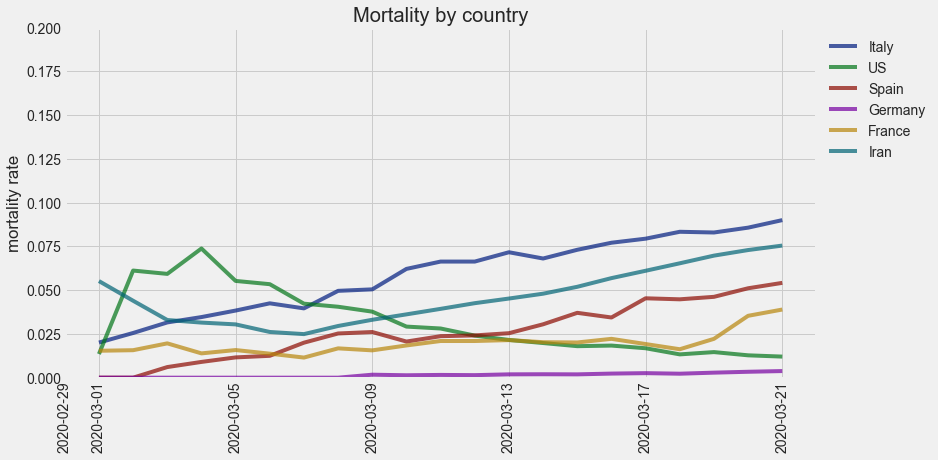

In [859]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

### Is mortality rate a function of number of infections?

In [860]:
def plot_mortality_rate_vs_infections(
    dfp, 
    locales, 
    id_col='country', 
    upper_lim=0.2, 
    date_min=datetime.datetime(2020,2,20)
):
    
    for locale in locales:
        dfp_plot = dfp[(dfp[id_col] == locale) &
                       (dfp['date'] >= date_min)
                      ]
        plt.plot(dfp_plot['confirmed'], dfp_plot['mortality_rate'], 'o', label=locale, alpha=0.3)
    plt.legend(loc='best')
    #plt.ylim([0,upper_lim])
    plt.gca().set_ylim(top=upper_lim)
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('# confirmed cases')
    plt.ylabel('mortality rate')
    plt.title(f'Mortality vs confirmed cases by {id_col}')
    plt.xticks(rotation=90)
    plt.show()
    return None

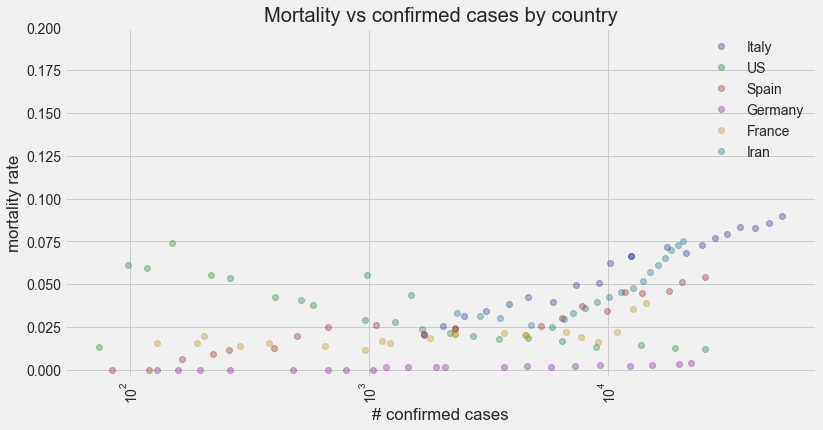

In [861]:
plot_mortality_rate_vs_infections(dfp_country, countries, upper_lim=0.2, id_col='country', date_min=datetime.datetime(2020,3,1))

# Compare mortality rate to expected given country demographics and mortality by age data?

- Country demographic data source: https://www.census.gov/data-tools/demo/idb/region.php?T=10&RT=0&A=both&Y=2020&C=AF&R=1
- Mortality by age source: https://www.worldometers.info/coronavirus/coronavirus-age-sex-demographics/

In [862]:
# mortality data
d_mortality = {0: 0, 10: 0.002, 20: 0.002, 30: 0.002, 40: 0.004, 50: 0.013, 60: 0.036, 70: 0.08, 80: 0.148, 90: 0.148, 100: 0.148}
dfp_mortality = pd.DataFrame.from_dict(d_mortality, orient='index', columns=['mortality_rate']).reset_index(drop=False)
dfp_mortality = dfp_mortality.rename(columns={'index': 'age_decade'})

# demographic data
dfp_demo = pd.read_csv('supporting_data/census_data_20200320_10a682338c.csv', skiprows=1, skipinitialspace=True)

# clean demographic data
dfp_demo = dfp_demo[(dfp_demo['Region'] == 'World') & (dfp_demo['Age'] != 'Total')]
dfp_demo['age_min'] = dfp_demo['Age'].apply(lambda x: np.min([int(y) for y in re.findall('(\d+)', x)]))
dfp_demo['age_mid'] = dfp_demo['age_min'] + 2.5
dfp_demo['age_decade'] = dfp_demo['age_min'].apply(lambda x: int(x / 10) * 10)
dfp_demo = dfp_demo.rename(columns={'Percent Both Sexes': 'pct_pop', 
                                    'Country': 'country',
                                    'Both Sexes Population': 'pop'
                                   })
dfp_demo_decade = dfp_demo.groupby(['country', 'age_decade'], as_index=False).agg({'pct_pop': np.sum, 'pop': np.sum})
dfp_demo_decade.loc[dfp_demo_decade['country'] == 'United States', 'country'] = 'US'

# join mortality with demographics
dfp_demo_decade_mortality = (dfp_demo_decade.merge(dfp_mortality, on=['age_decade'], how='inner').
                             sort_values(by=['country', 'age_decade']).
                             reset_index(drop=True)
                            )
dfp_demo_decade_mortality['frac_mortality'] = dfp_demo_decade_mortality['pct_pop'] * dfp_demo_decade_mortality['mortality_rate'] / 100
dfp_demo_decade_mortality['num_deaths_max_expected'] = dfp_demo_decade_mortality['pop'] * dfp_demo_decade_mortality['mortality_rate']
dfp_country_mortality_expected = (dfp_demo_decade_mortality.
                                  groupby(['country'], as_index=False).
                                  agg({'frac_mortality': np.sum, 
                                       'num_deaths_max_expected': np.sum, 
                                       'pop': np.sum
                                      })
                                 )
dfp_country_mortality_expected.loc[dfp_country_mortality_expected['country'] == 'United States', 'country'] = 'US'

### Age distributions for most infected countries

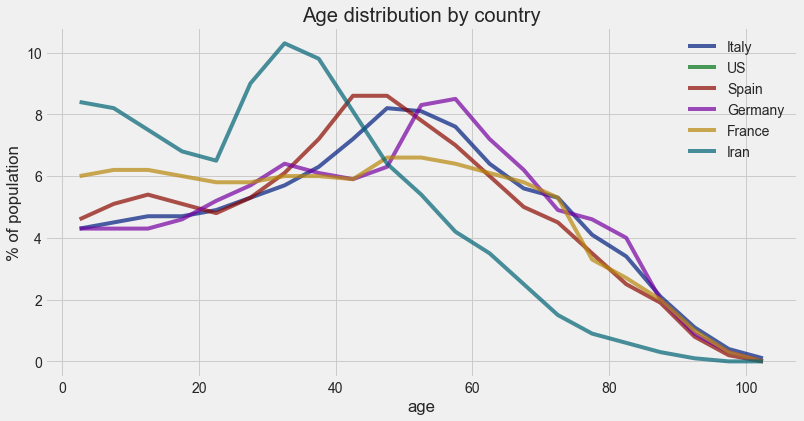

In [863]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']
for country in countries:
    dfp_plot = dfp_demo[dfp_demo.country == country]
    plt.plot(dfp_plot['age_mid'], dfp_plot['pct_pop'], alpha=0.7, label=country)
plt.xlabel('age')
plt.ylabel('% of population')
plt.title('Age distribution by country')
plt.legend(loc='best')
plt.show()

<a id='counry_mortality_expectations'></a>
### Mortality as currently measured, compared to expected based on WHO mortality expectations

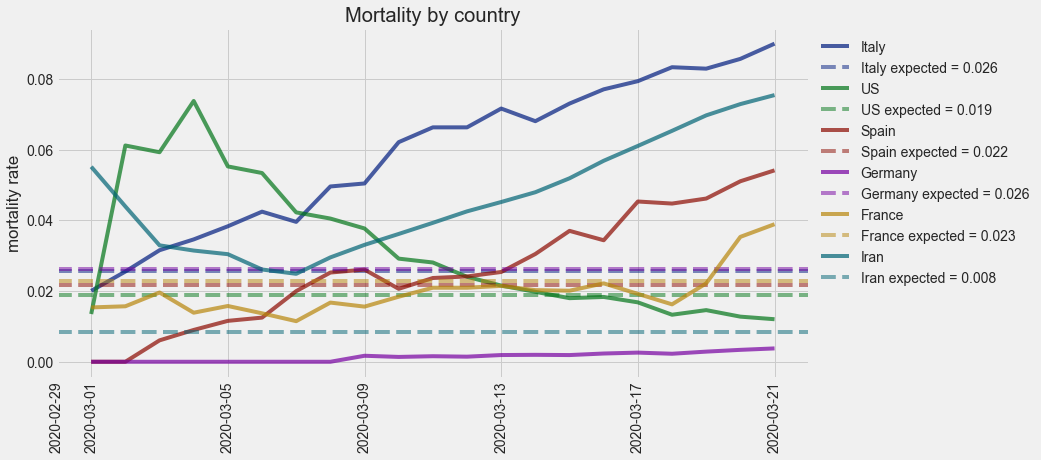

In [864]:
n_countries = 6
countries = dfp_top_countries.iloc[:n_countries]['country']

plot_mortality_rate(dfp_country, countries, upper_lim=None, id_col='country', date_min=datetime.datetime(2020,3,1), dfp_country_mortality_expected=dfp_country_mortality_expected)

### Distribution of expected mortality fractions

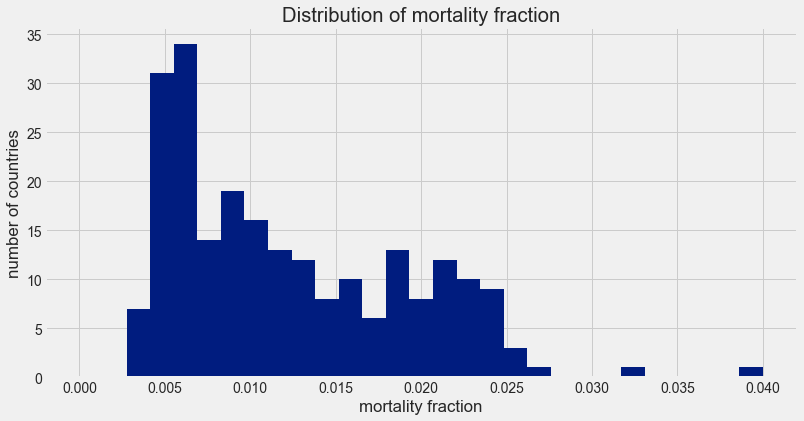

In [865]:
dfp_country_mortality_expected['frac_mortality'].hist(bins=np.linspace(0,0.04,30))
plt.title('Distribution of mortality fraction')
plt.ylabel('number of countries')
plt.xlabel('mortality fraction')
plt.show()

### Top expected mortality fractions based on age demographics
For countries with populations greater than 10 million.

In [866]:
dfp_country_mortality_expected = dfp_country_mortality_expected.sort_values(by='frac_mortality', ascending=0).reset_index(drop=True)
dfp_country_mortality_expected[dfp_country_mortality_expected['pop'] > 1E7].head(10)

,country,frac_mortality,num_deaths_max_expected,pop
1,Japan,0.031837,3998380.024,125507472
2,Germany,0.026398,2128411.026,80159662
3,Greece,0.025745,271233.247,10607051
4,Italy,0.025637,1599267.592,62402659
10,Portugal,0.023736,244829.259,10302674
18,France,0.022950,1564984.503,67848156
20,Sweden,0.022575,231555.716,10202491
23,Belgium,0.022146,259573.363,11720716
24,Netherlands,0.022076,382222.125,17280397
27,Canada,0.021712,820035.480,37694085


# Normalize infections by population

Population data taken from https://www.worldometers.info/world-population/population-by-country/ on 2020-03-16

In [867]:
dfp_world_pop = pd.read_csv('supporting_data/country_population_data.csv')

In [868]:
# clean population data
dfp_world_pop = dfp_world_pop.rename(columns={
    'Country (or dependency)': 'country', 
    'Population\n (2020)': 'population'
})
dfp_world_pop['population'] = dfp_world_pop['population'].apply(lambda x: float(x.replace(',', '')))

In [869]:
translations = {'South Korea': 'Korea, South',
                'United States': 'US',
               }
for old, new in translations.items():
    try:
        dfp_world_pop['country'][np.where(dfp_world_pop['country'] == old)[0][0]] = new
    except Exception as e:
        pass  #print(e)

/Users/tboats/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [870]:
# filter in only the top countries
top_n = 10
pop_cols = ['country', 'population']
dfp_country_top = dfp_country.merge(dfp_top_countries.iloc[:top_n]['country'], on='country', how='inner')
dfp_country_top_dec = dfp_country_top.merge(dfp_world_pop[pop_cols], on='country', how='left')
dfp_country_top_dec['confirmed_frac'] = dfp_country_top_dec['confirmed'] / dfp_country_top_dec['population']
dfp_country_top_dec['deaths_frac'] = dfp_country_top_dec['deaths'] / dfp_country_top_dec['population']

<a id='days_behind'></a>
# How many days behind is each country from Italy?

In [871]:
def days_behind_multi_country(
    countries_compare, 
    country_base, 
    dfp=dfp_country_top_dec, 
    n_days=14, 
    country_col='country',
    compare_col='confirmed_frac'
):
#     country_compare = 'Spain'
#     country_base = 'Italy'
    countries = [country_base] + countries_compare
    #n_days = 14  # compare the lag over the last n_days

    # compare the fraction of cases directly
    list_dfp_compare = []
    d_dfp_compare = {}

    for i, country in enumerate(countries):
        dfp_p = dfp[dfp[country_col] == country]
        dfp_p = dfp_p.sort_values(by='date', ascending=0).reset_index(drop=True)
        
        if country == country_base:
            line_style = '-'
            dfp_comp = dfp_p.copy()
            alpha=1
        else:
            line_style = '--'
            list_dfp_compare.append(dfp_p)
            d_dfp_compare[country] = dfp_p
            alpha=0.7
        
        plt.plot(dfp_p['date'], dfp_p['confirmed'], linestyle=line_style, alpha=alpha, label=country)
        
    plt.legend(loc='best')
    plt.title('Raw number of cases')
    plt.ylabel('cases')
    plt.yscale('log')
    plt.show()


    # compute the best estimate of the lag between countries
    # this assumes that the best metric is density of cases
    # though this may be more dependent on localities
    metric = compare_col
    delta_col = f'delta_{metric}'
    list_series = []

    for country, dfp_test in d_dfp_compare.items():
        list_series = []
        delta_col = f'delta_{metric}_{country}'
        for i, row in dfp_test[:n_days].iterrows():
            dfp_comp[delta_col] = np.abs(dfp_comp[metric] - row[metric])
            min_loc = dfp_comp[delta_col] == dfp_comp[delta_col].min()
            #print(row['date'] - dfp_comp[min_loc]['date'])
            days_diff = pd.to_timedelta(row['date'] - dfp_comp[min_loc]['date']).astype('timedelta64[D]').values[0]
            row['days_diff'] = days_diff
            row['country_compare'] = country
            list_series.append(row)

        # plot days behind
        dfp_days_behind = pd.concat(list_series, axis=1).T
        plt.plot(dfp_days_behind['date'], dfp_days_behind['days_diff'], label=country, alpha=0.5)
        mean_days_diff = dfp_days_behind['days_diff'].mean()#{str(dfp['date'].max())}
        date_max = dfp['date'].max().strftime('%Y-%m-%d')
    plt.axhline(0, label='0', color='k', linestyle='--', alpha=0.5)
    #print(f'Computing how far behind a country is using the {compare_col} column:')
    plt.title(f'Number days each {country_col} is from {country_base} as of {date_max} using {compare_col}')
    plt.ylabel('# days')
    plt.legend(loc='best')
    plt.show()
    return dfp_days_behind

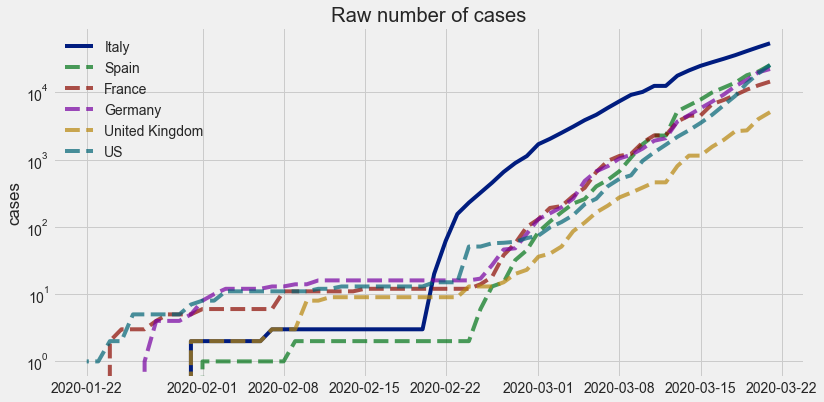

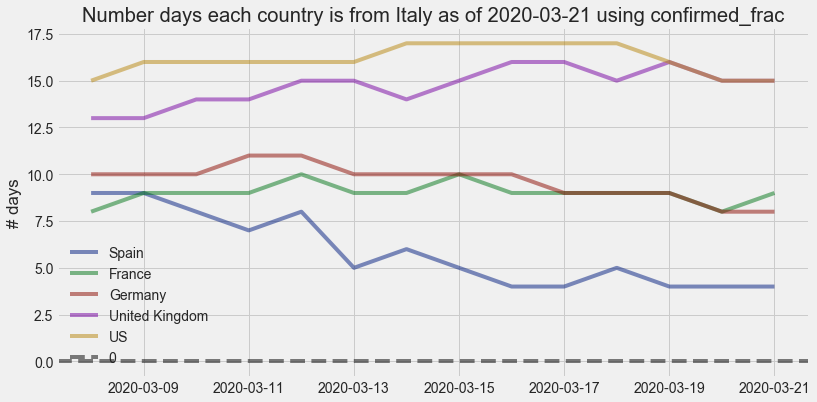

In [872]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', compare_col='confirmed_frac')

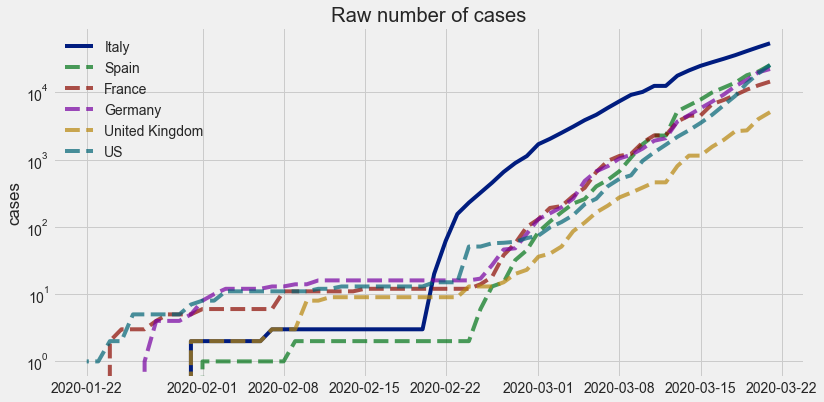

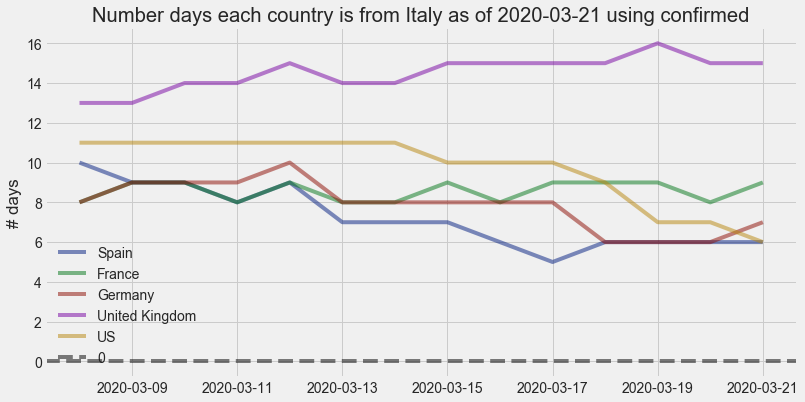

In [873]:
_ = days_behind_multi_country(['Spain', 'France', 'Germany', 'United Kingdom', 'US'], 'Italy', compare_col='confirmed')

# US state breakdown

In [884]:
# look only at the US
dfp_us_raw = dfp[dfp['country'] == 'US'].copy()
dfp_us_raw['state_clean_1'] = dfp_us_raw['state'].apply(lambda x: re.findall('\, ([A-Z]{2})', x)[0].strip() if re.findall('\, ([A-Z]{2})', x) else x)

# load codes to convert two-letter codes to state names
dfp_state_codes = pd.read_csv('supporting_data/us_state_to_two_letter_code.csv')
dfp_state_codes = dfp_state_codes.rename(columns={'state': 'state_name'})
dfp_us = dfp_us_raw.merge(dfp_state_codes, left_on=['state_clean_1'], right_on=['two_letter_code'], how='left')

In [875]:
# get the most appropriate state name
dfp_us['abbrev'] = ~dfp_us['state_name'].isnull()
dfp_us['state_clean'] = dfp_us.apply(lambda x: x['state_name'] if x['abbrev'] else x['state_clean_1'], axis=1)

# aggregate infections by state
dfp_us_g = (dfp_us.groupby(['date', 'country', 'state_clean'], as_index=False).
            agg({
                'confirmed': np.sum,
                'deaths': np.sum,
                'recovered': np.sum,
               })
           )
dfp_us_g = dfp_us_g.sort_values(by='date')
dfp_us_g = dfp_us_g.rename(columns={'state_clean': 'state'})
dfp_us_g['active'] = dfp_us_g['confirmed'] - dfp_us_g['recovered']
dfp_us_g['confirmed_lag1'] = dfp_us_g.groupby(['country', 'state'])['confirmed'].shift(1)
dfp_us_g['deaths_lag1'] = dfp_us_g.groupby(['country', 'state'])['deaths'].shift(1)
dfp_us_g['confirmed_new'] = dfp_us_g['confirmed'] - dfp_us_g['confirmed_lag1']
dfp_us_g['deaths_new'] = dfp_us_g['deaths'] - dfp_us_g['deaths_lag1']
dfp_us_g['mortality_rate'] = dfp_us_g['deaths'] / dfp_us_g['confirmed']

<a id='states_most_infections'></a>
### US states with the most new infections

In [876]:
id_cols_state = ['date', 'state']

dfp_us_top_states = dfp_us_g[dfp_us_g['date'] == dfp_us_g['date'].max()][id_cols_state + value_cols]
dfp_us_top_states = dfp_us_top_states.sort_values(by='active', ascending=0).reset_index(drop=True)
for key in value_cols:
    if 'rate' in key:
        continue
    dfp_us_top_states[key] = dfp_us_top_states[key].apply(int)
dfp_us_top_states.head(10)

,date,state,confirmed,confirmed_new,deaths,deaths_new,active,mortality_rate
0,2020-03-21,New York,11710,3400,60,18,11710,0.005124
1,2020-03-21,Washington,1793,269,94,11,1793,0.052426
2,2020-03-21,California,1364,187,24,1,1364,0.017595
3,2020-03-21,New Jersey,1327,437,16,5,1327,0.012057
4,2020-03-21,Michigan,788,236,5,2,788,0.006345
5,2020-03-21,Illinois,753,168,6,1,753,0.007968
6,2020-03-21,Florida,659,96,13,3,659,0.019727
7,2020-03-21,Louisiana,585,47,16,2,585,0.027350
8,2020-03-21,Texas,581,187,5,0,581,0.008606
9,2020-03-21,Massachusetts,525,112,1,0,525,0.001905


<a id='time-series_states'></a>
### Time-series plots of infections in most-infected states

In [877]:
def plot_state_data(dfp_us_g, states_oi, plot_col='confirmed', date_min=datetime.datetime(2020, 2, 25)):
    for state in states_oi:
        dfp_s = dfp_us_g[(dfp_us_g['state'] == state) & (dfp_us_g['date'] >= date_min)]
        plt.plot(dfp_s['date'], dfp_s[plot_col], label=state, alpha=0.5)
    plt.ylabel('# cases')
    plt.xticks(rotation=90)
    plt.title(f'{plot_col} in: {", ".join(states_oi)}')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.show()
    return None

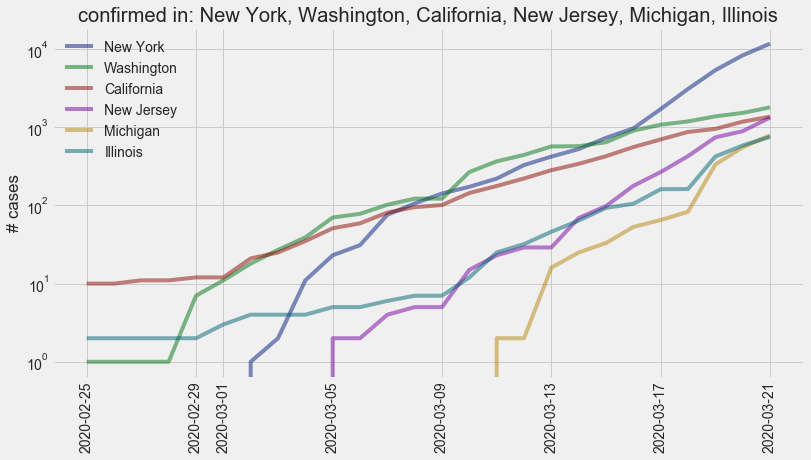

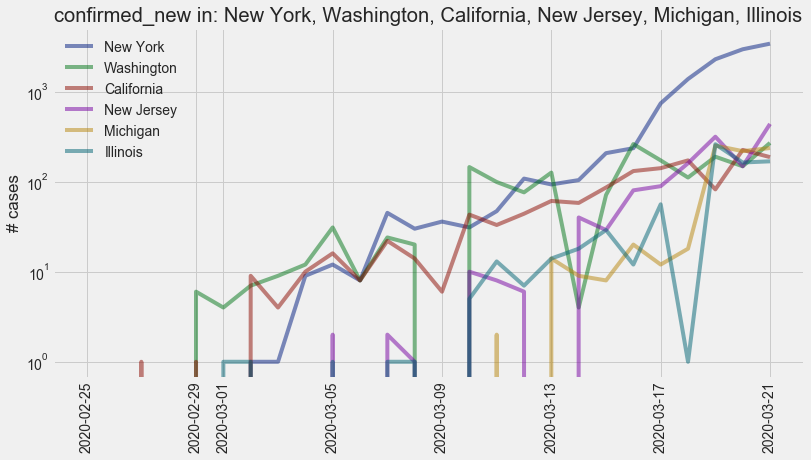

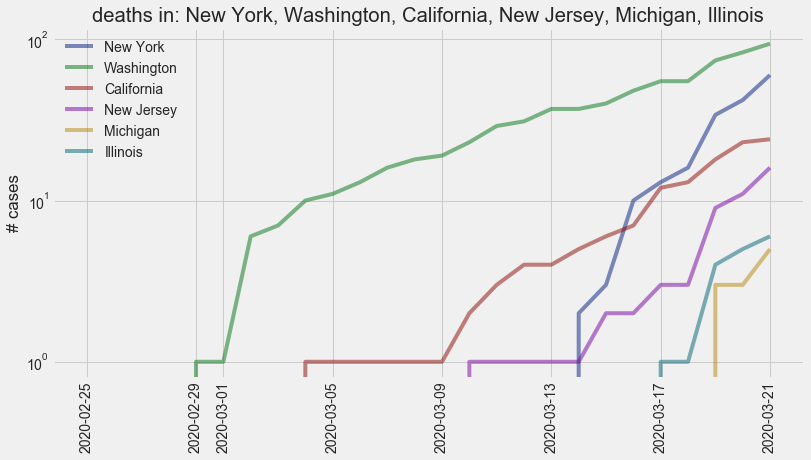

In [878]:
states_oi = dfp_us_top_states.iloc[:6]['state'].values
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed')
plot_state_data(dfp_us_g, states_oi, plot_col='confirmed_new')
plot_state_data(dfp_us_g, states_oi, plot_col='deaths')

<a id='state_infections_vs_wa'></a>
##### Compare US state infections against Washington

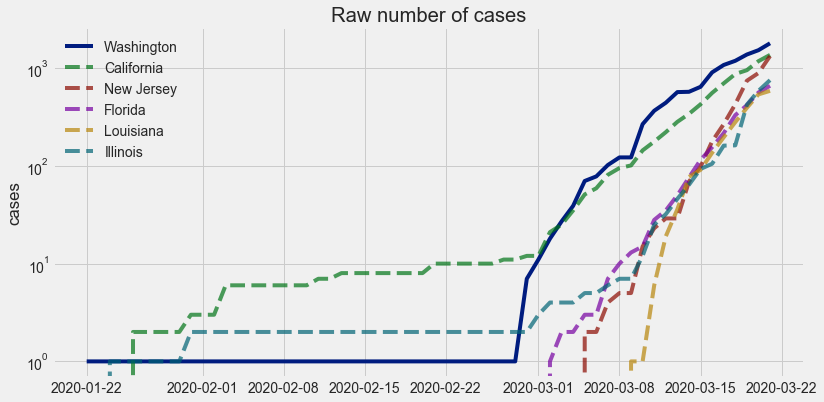

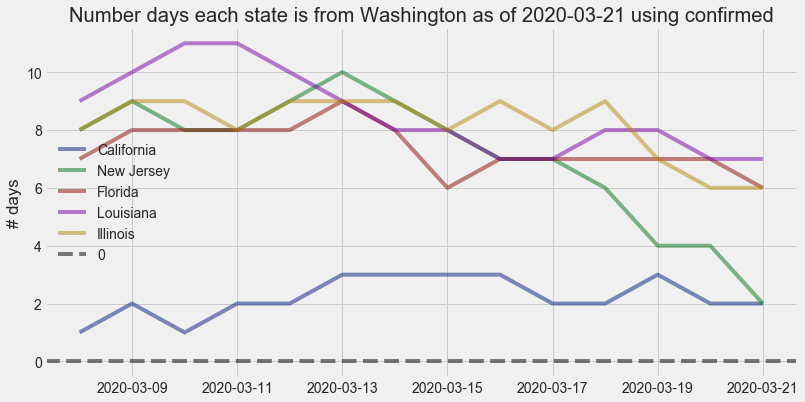

In [879]:
_ = days_behind_multi_country(['California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'Washington', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='state_infections_vs_ny'></a>
##### Compare US state infections against New York

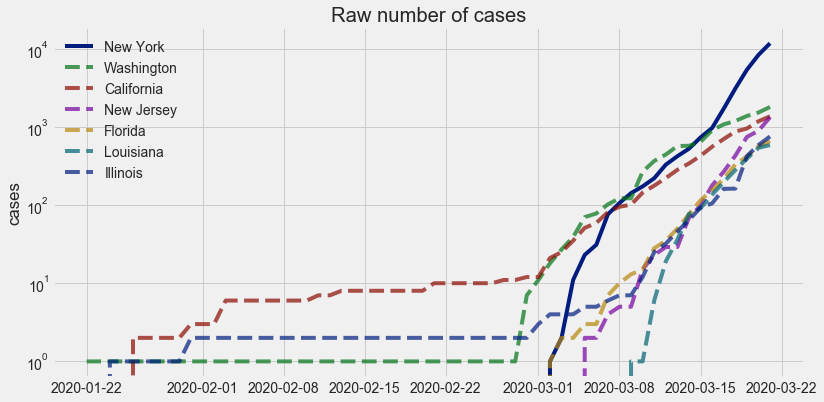

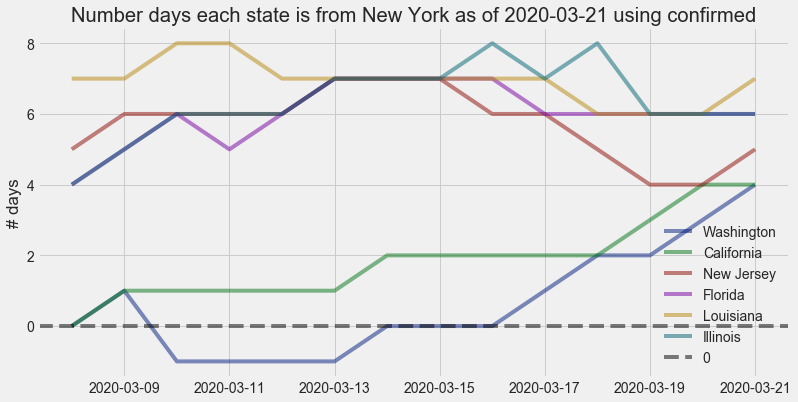

In [880]:
_ = days_behind_multi_country(['Washington', 'California', 'New Jersey', 'Florida', 'Louisiana', 'Illinois'], 
                              'New York', 
                              dfp=dfp_us_g, 
                              country_col='state', 
                              compare_col='confirmed'
                             )

<a id='mortality_by_us_state'></a>
### Mortality rate by US state

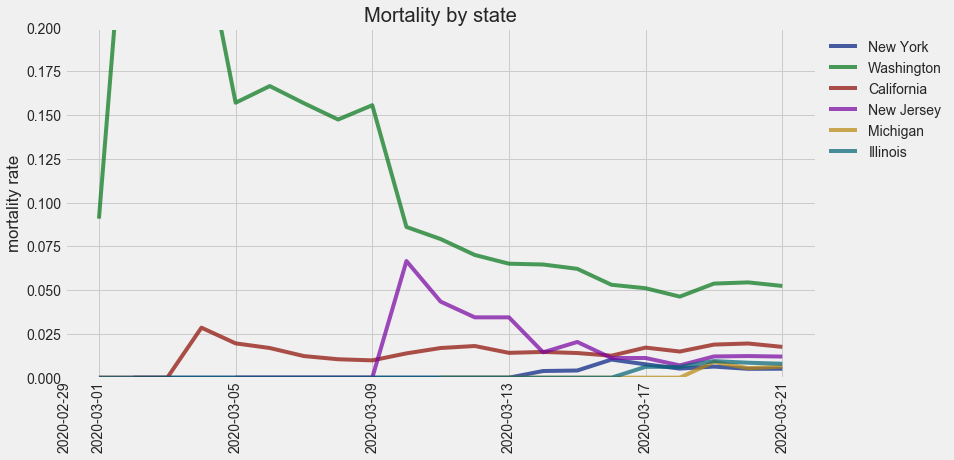

In [881]:
n_states = 6
states = dfp_us_top_states.iloc[:n_states]['state']

plot_mortality_rate(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))

##### Relationship between mortality rate and number of cases

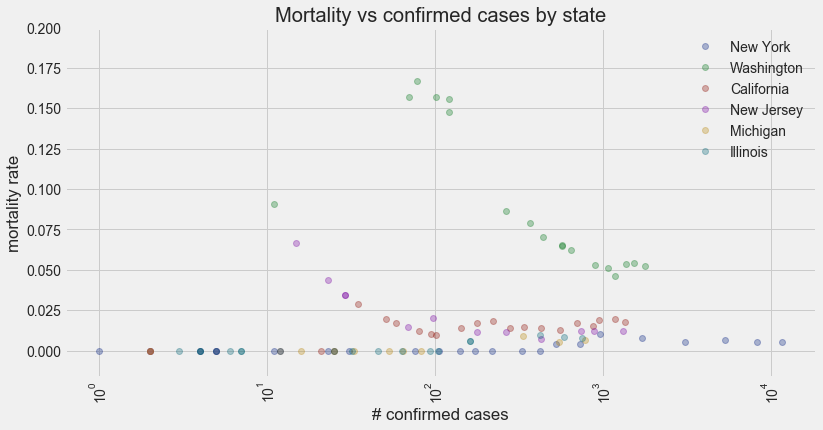

In [882]:
plot_mortality_rate_vs_infections(dfp_us_g, states, upper_lim=0.2, id_col='state', date_min=datetime.datetime(2020,3,1))